# Student Satisfaction Rating Prediction with 3 Models

This notebook demonstrates how to predict student satisfaction ratings using three different machine learning models: Ridge Regression, Multi-Layer Perceptron, and CNN for Tabular Data. We'll analyze the relationship between various student session features and their satisfaction ratings.

**Goal:** Predict next student's satisfaction rating (1.0 to 5.0)

**Input Features:** StudentLevel, Discipline, SessionLengthMin, TotalPrompts, TaskType, AI_AssistanceLevel etc.

## 1. Import Required Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge, Lasso
from sklearn.neural_network import MLPRegressor
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, Flatten, Reshape
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print("Libraries imported successfully!")

Libraries imported successfully!


## 2. Load and Explore the Dataset

In [2]:
# Load the dataset
df = pd.read_csv('https://raw.githubusercontent.com/guixuan/AISV.X401.21.finalProject/main/ai_assistant_usage_student_life.csv')

print("=" * 80)
print("3 MODELS FOR SATISFACTION RATING PREDICTION")
print("Goal: Predict next student's satisfaction rating")
print("Input: StudentLevel, Discipline, SessionLengthMin, TotalPrompts, TaskType, AI_AssistanceLevel")
print("Output: SatisfactionRating (1.0 to 5.0)")
print("=" * 80)

print(f"Dataset loaded: {df.shape[0]} sessions, {df.shape[1]} features")

print(f"\nSatisfactionRating Analysis:")
print(f"   Range: [{df['SatisfactionRating'].min():.1f}, {df['SatisfactionRating'].max():.1f}]")
print(f"   Mean: {df['SatisfactionRating'].mean():.2f}")
print(f"   Std: {df['SatisfactionRating'].std():.2f}")
print(f"   Distribution: {df['SatisfactionRating'].value_counts().sort_index().to_dict()}")

print(f"\nInput Features Analysis:")
print(f"   StudentLevel: {df['StudentLevel'].value_counts().to_dict()}")
print(f"   Discipline: {df['Discipline'].nunique()} disciplines")
print(f"   TaskType: {df['TaskType'].nunique()} task types")
print(f"   SessionLengthMin: Mean={df['SessionLengthMin'].mean():.1f}min")
print(f"   TotalPrompts: Mean={df['TotalPrompts'].mean():.1f}")
print(f"   AI_AssistanceLevel: Range=[{df['AI_AssistanceLevel'].min()}, {df['AI_AssistanceLevel'].max()}]")

# Correlation analysis with satisfaction
print(f"\nCorrelation with SatisfactionRating:")
numerical_features = ['SessionLengthMin', 'TotalPrompts', 'AI_AssistanceLevel']
for feature in numerical_features:
    corr = df[feature].corr(df['SatisfactionRating'])
    print(f"   {feature}: {corr:.3f}")

3 MODELS FOR SATISFACTION RATING PREDICTION
Goal: Predict next student's satisfaction rating
Input: StudentLevel, Discipline, SessionLengthMin, TotalPrompts, TaskType, AI_AssistanceLevel
Output: SatisfactionRating (1.0 to 5.0)
Dataset loaded: 10000 sessions, 11 features

SatisfactionRating Analysis:
   Range: [1.0, 5.0]
   Mean: 3.42
   Std: 1.14
   Distribution: {1.0: 354, 1.1: 54, 1.2: 74, 1.3: 77, 1.4: 95, 1.5: 78, 1.6: 105, 1.7: 127, 1.8: 127, 1.9: 141, 2.0: 145, 2.1: 158, 2.2: 202, 2.3: 219, 2.4: 219, 2.5: 226, 2.6: 233, 2.7: 249, 2.8: 256, 2.9: 278, 3.0: 252, 3.1: 296, 3.2: 289, 3.3: 289, 3.4: 310, 3.5: 311, 3.6: 303, 3.7: 284, 3.8: 311, 3.9: 293, 4.0: 272, 4.1: 275, 4.2: 274, 4.3: 252, 4.4: 235, 4.5: 258, 4.6: 229, 4.7: 215, 4.8: 211, 4.9: 188, 5.0: 1236}

Input Features Analysis:
   StudentLevel: {'Undergraduate': 5978, 'High School': 2027, 'Graduate': 1995}
   Discipline: 7 disciplines
   TaskType: 6 task types
   SessionLengthMin: Mean=19.8min
   TotalPrompts: Mean=5.6
   AI_

## 3. Data Preprocessing

In [3]:
print("Data Preprocessing for Satisfaction Prediction...")

# One-hot encode categorical variables
X_encoded = pd.DataFrame()
categorical_features = ['StudentLevel', 'Discipline', 'TaskType']

for feature in categorical_features:
    encoded = pd.get_dummies(df[feature], prefix=feature)
    X_encoded = pd.concat([X_encoded, encoded], axis=1)
    print(f"   Encoded {feature}: {len(encoded.columns)} categories")

# Add numerical features
numerical_features = ['SessionLengthMin', 'TotalPrompts', 'AI_AssistanceLevel']
for feature in numerical_features:
    X_encoded[feature] = df[feature]

# Create interaction features
X_encoded['AI_Session_Interaction'] = df['AI_AssistanceLevel'] * df['SessionLengthMin']
X_encoded['AI_Prompts_Interaction'] = df['AI_AssistanceLevel'] * df['TotalPrompts']
X_encoded['Session_Prompts_Ratio'] = df['TotalPrompts'] / (df['SessionLengthMin'] + 1e-8)

# Scale numerical features
scaler = StandardScaler()
numerical_cols = numerical_features + ['AI_Session_Interaction', 'AI_Prompts_Interaction', 'Session_Prompts_Ratio']
X_encoded[numerical_cols] = scaler.fit_transform(X_encoded[numerical_cols])

X = X_encoded
feature_names = X_encoded.columns.tolist()
y = df['SatisfactionRating']

print(f"Final feature matrix: {X.shape}")
print(f"Features: {len(feature_names)} total features")
print(f"Target: SatisfactionRating [{y.min():.1f}, {y.max():.1f}]")

Data Preprocessing for Satisfaction Prediction...
   Encoded StudentLevel: 3 categories
   Encoded Discipline: 7 categories
   Encoded TaskType: 6 categories
Final feature matrix: (10000, 22)
Features: 22 total features
Target: SatisfactionRating [1.0, 5.0]


## 4. Exploratory Data Analysis

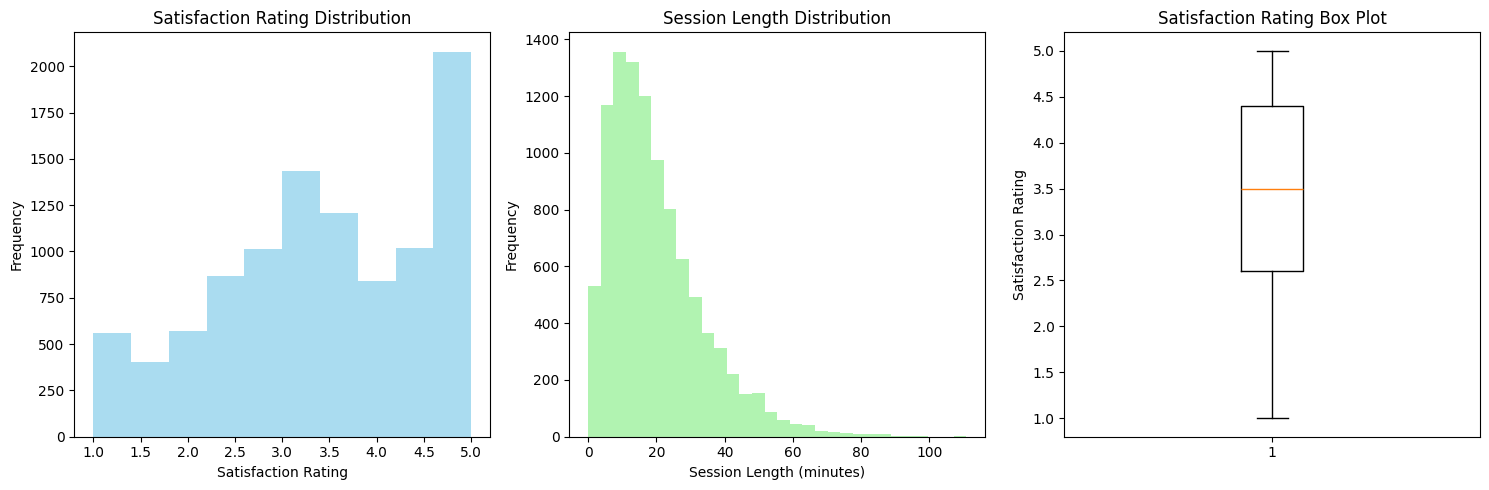

Satisfaction Rating statistics:
Mean: 3.42
Median: 3.50
Min: 1.00
Max: 5.00


In [4]:
# Satisfaction rating distribution
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.hist(df['SatisfactionRating'], bins=10, alpha=0.7, color='skyblue')
plt.title('Satisfaction Rating Distribution')
plt.xlabel('Satisfaction Rating')
plt.ylabel('Frequency')

plt.subplot(1, 3, 2)
plt.hist(df['SessionLengthMin'], bins=30, alpha=0.7, color='lightgreen')
plt.title('Session Length Distribution')
plt.xlabel('Session Length (minutes)')
plt.ylabel('Frequency')

plt.subplot(1, 3, 3)
plt.boxplot(df['SatisfactionRating'])
plt.title('Satisfaction Rating Box Plot')
plt.ylabel('Satisfaction Rating')

plt.tight_layout()
plt.show()

print(f"Satisfaction Rating statistics:")
print(f"Mean: {df['SatisfactionRating'].mean():.2f}")
print(f"Median: {df['SatisfactionRating'].median():.2f}")
print(f"Min: {df['SatisfactionRating'].min():.2f}")
print(f"Max: {df['SatisfactionRating'].max():.2f}")

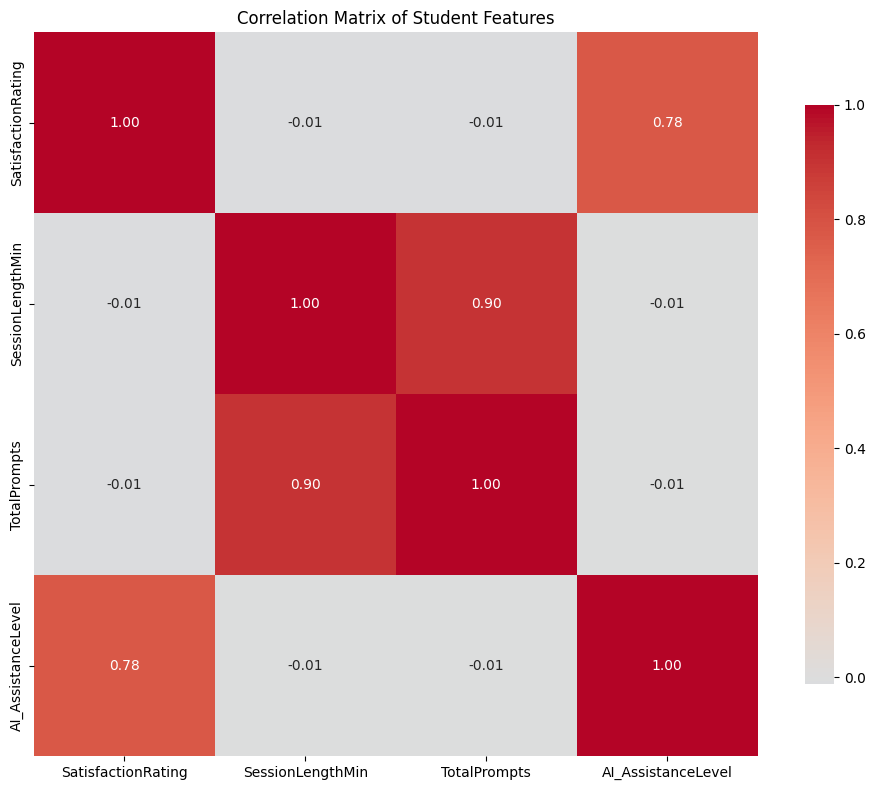


Features most correlated with satisfaction:
SatisfactionRating    1.000000
AI_AssistanceLevel    0.775513
SessionLengthMin      0.011136
TotalPrompts          0.009561
Name: SatisfactionRating, dtype: float64


In [5]:
# Correlation matrix for numerical features
numerical_features = ['SatisfactionRating', 'SessionLengthMin', 'TotalPrompts', 'AI_AssistanceLevel']

plt.figure(figsize=(10, 8))
correlation_matrix = df[numerical_features].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
            square=True, fmt='.2f', cbar_kws={'shrink': 0.8})
plt.title('Correlation Matrix of Student Features')
plt.tight_layout()
plt.show()

# Show features most correlated with satisfaction
satisfaction_corr = correlation_matrix['SatisfactionRating'].abs().sort_values(ascending=False)
print("\nFeatures most correlated with satisfaction:")
print(satisfaction_corr)

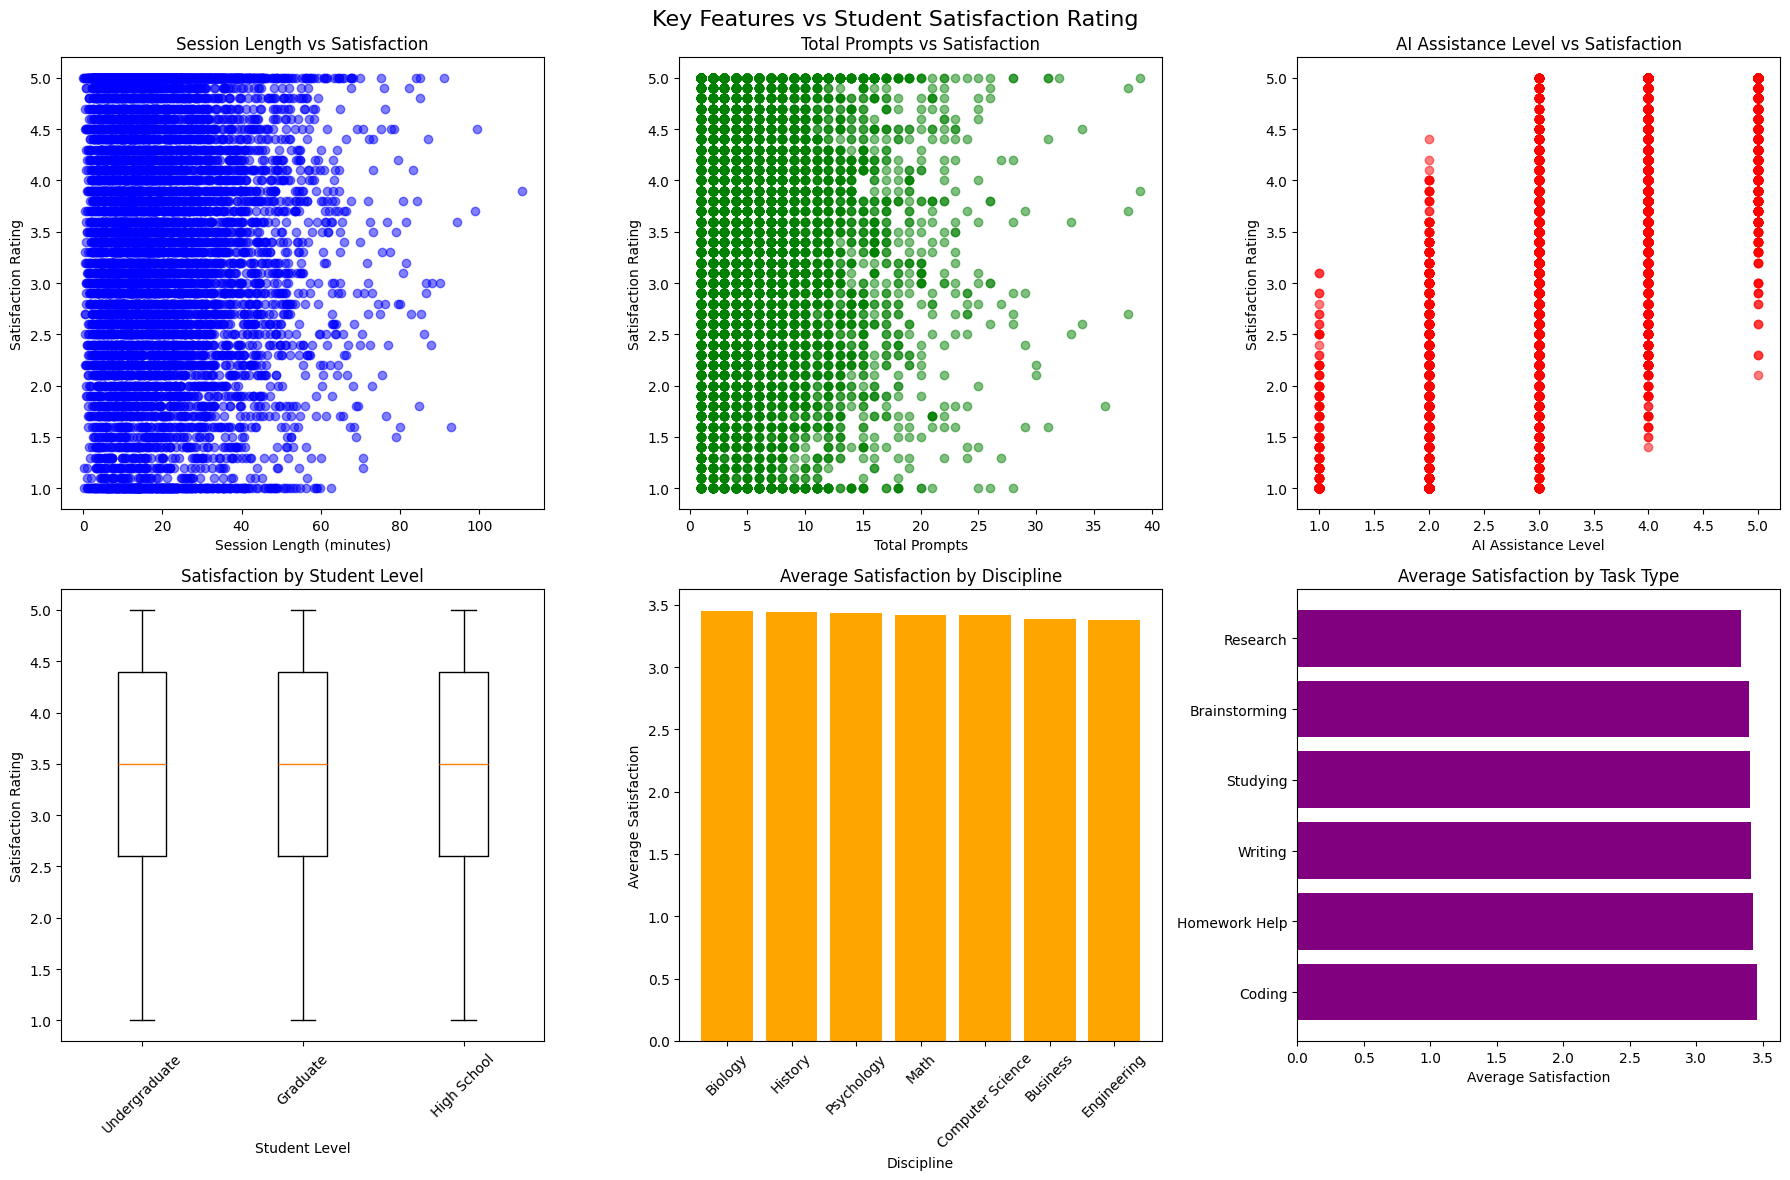

In [6]:
# Scatter plots of key features vs satisfaction
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Key Features vs Student Satisfaction Rating', fontsize=16)

# SessionLengthMin vs satisfaction
axes[0, 0].scatter(df['SessionLengthMin'], df['SatisfactionRating'], alpha=0.5, color='blue')
axes[0, 0].set_xlabel('Session Length (minutes)')
axes[0, 0].set_ylabel('Satisfaction Rating')
axes[0, 0].set_title('Session Length vs Satisfaction')

# TotalPrompts vs satisfaction
axes[0, 1].scatter(df['TotalPrompts'], df['SatisfactionRating'], alpha=0.5, color='green')
axes[0, 1].set_xlabel('Total Prompts')
axes[0, 1].set_ylabel('Satisfaction Rating')
axes[0, 1].set_title('Total Prompts vs Satisfaction')

# AI_AssistanceLevel vs satisfaction
axes[0, 2].scatter(df['AI_AssistanceLevel'], df['SatisfactionRating'], alpha=0.5, color='red')
axes[0, 2].set_xlabel('AI Assistance Level')
axes[0, 2].set_ylabel('Satisfaction Rating')
axes[0, 2].set_title('AI Assistance Level vs Satisfaction')

# StudentLevel vs satisfaction (box plot)
student_levels = df['StudentLevel'].unique()
satisfaction_by_level = [df[df['StudentLevel'] == level]['SatisfactionRating'].values for level in student_levels]
axes[1, 0].boxplot(satisfaction_by_level, labels=student_levels)
axes[1, 0].set_title('Satisfaction by Student Level')
axes[1, 0].set_xlabel('Student Level')
axes[1, 0].set_ylabel('Satisfaction Rating')
axes[1, 0].tick_params(axis='x', rotation=45)

# Discipline vs satisfaction (bar plot)
discipline_satisfaction = df.groupby('Discipline')['SatisfactionRating'].mean().sort_values(ascending=False)
axes[1, 1].bar(range(len(discipline_satisfaction)), discipline_satisfaction.values, color='orange')
axes[1, 1].set_xticks(range(len(discipline_satisfaction)))
axes[1, 1].set_xticklabels(discipline_satisfaction.index, rotation=45)
axes[1, 1].set_title('Average Satisfaction by Discipline')
axes[1, 1].set_xlabel('Discipline')
axes[1, 1].set_ylabel('Average Satisfaction')

# TaskType vs satisfaction (bar plot)
task_satisfaction = df.groupby('TaskType')['SatisfactionRating'].mean().sort_values(ascending=False)
axes[1, 2].barh(range(len(task_satisfaction)), task_satisfaction.values, color='purple')
axes[1, 2].set_yticks(range(len(task_satisfaction)))
axes[1, 2].set_yticklabels(task_satisfaction.index)
axes[1, 2].set_title('Average Satisfaction by Task Type')
axes[1, 2].set_xlabel('Average Satisfaction')

plt.tight_layout()
plt.show()

## 5. Model 1: Ridge Regression

**Why Perfect for Satisfaction Prediction:**
- Designed for regression tasks
- L2 regularization prevents overfitting on small dataset
- Interpretable coefficients show feature importance
- Fast training and prediction
- Handles multicollinearity well

In [7]:
print("MODEL 1: RIDGE REGRESSION (Week 1-2)")
print("Perfect for tabular regression with regularization")
print("=" * 70)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Hyperparameter tuning
param_grid = {'alpha': [0.01, 0.1, 1, 10, 100, 1000]}
ridge = Ridge()
grid_search = GridSearchCV(ridge, param_grid, cv=5, scoring='r2')
grid_search.fit(X_train, y_train)

# Best model
best_ridge = grid_search.best_estimator_

# Predictions
y_pred_train = best_ridge.predict(X_train)
y_pred_test = best_ridge.predict(X_test)

# Metrics
train_r2 = r2_score(y_train, y_pred_train)
test_r2 = r2_score(y_test, y_pred_test)
test_mse = mean_squared_error(y_test, y_pred_test)
test_mae = mean_absolute_error(y_test, y_pred_test)

# Cross-validation
cv_scores = cross_val_score(best_ridge, X, y, cv=5, scoring='r2')

ridge_results = {
    'model': best_ridge,
    'best_params': grid_search.best_params_,
    'train_r2': train_r2,
    'test_r2': test_r2,
    'test_mse': test_mse,
    'test_mae': test_mae,
    'cv_mean': cv_scores.mean(),
    'cv_std': cv_scores.std(),
    'predictions': y_pred_test,
    'y_test': y_test,
    'feature_importance': dict(zip(feature_names, np.abs(best_ridge.coef_)))
}

print(f"Best parameters: {grid_search.best_params_}")
print(f"Train R²: {train_r2:.4f}")
print(f"Test R²: {test_r2:.4f}")
print(f"Test MSE: {test_mse:.4f}")
print(f"Test MAE: {test_mae:.4f}")
print(f"CV R²: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

# Feature importance
feature_importance = ridge_results['feature_importance']
top_features = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)[:5]
print(f"Top 5 Important Features:")
for feature, importance in top_features:
    print(f"   - {feature}: {importance:.4f}")

MODEL 1: RIDGE REGRESSION (Week 1-2)
Perfect for tabular regression with regularization
Best parameters: {'alpha': 10}
Train R²: 0.6006
Test R²: 0.6025
Test MSE: 0.5186
Test MAE: 0.5702
CV R²: 0.5999 ± 0.0117
Top 5 Important Features:
   - AI_AssistanceLevel: 0.8747
   - Discipline_Psychology: 0.0401
   - Discipline_Business: 0.0359
   - Session_Prompts_Ratio: 0.0345
   - TaskType_Brainstorming: 0.0343


## 6. Model 2: Multi-Layer Perceptron

**Why Excellent for Satisfaction Prediction:**
- Universal function approximator for complex patterns
- Captures non-linear relationships in student behavior
- Dropout regularization perfect for small datasets
- Can learn complex feature interactions

In [8]:
print("MODEL 2: MULTI-LAYER PERCEPTRON")
print("Neural network for non-linear satisfaction patterns")
print("=" * 70)

# Split data (same split as Ridge for fair comparison)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build MLP model
mlp_model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.25),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dropout(0.1),
    Dense(1, activation='linear')
])

# Compile model
mlp_model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True, verbose=0)

# Train model
history = mlp_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=200,
    batch_size=8,
    callbacks=[early_stopping],
    verbose=0
)

# Predictions
y_pred_train = mlp_model.predict(X_train, verbose=0).flatten()
y_pred_test = mlp_model.predict(X_test, verbose=0).flatten()

# Metrics
train_r2 = r2_score(y_train, y_pred_train)
test_r2 = r2_score(y_test, y_pred_test)
test_mse = mean_squared_error(y_test, y_pred_test)
test_mae = mean_absolute_error(y_test, y_pred_test)

mlp_results = {
    'model': mlp_model,
    'train_r2': train_r2,
    'test_r2': test_r2,
    'test_mse': test_mse,
    'test_mae': test_mae,
    'predictions': y_pred_test,
    'y_test': y_test,
    'history': history,
    'epochs_trained': len(history.history['loss'])
}

print(f"Train R²: {train_r2:.4f}")
print(f"Test R²: {test_r2:.4f}")
print(f"Test MSE: {test_mse:.4f}")
print(f"Test MAE: {test_mae:.4f}")
print(f"Epochs trained: {len(history.history['loss'])}")
print(f"Final train loss: {history.history['loss'][-1]:.4f}")
print(f"Final val loss: {history.history['val_loss'][-1]:.4f}")

MODEL 2: MULTI-LAYER PERCEPTRON
Neural network for non-linear satisfaction patterns
Train R²: 0.6030
Test R²: 0.6042
Test MSE: 0.5164
Test MAE: 0.5804
Epochs trained: 35
Final train loss: 0.5536
Final val loss: 0.5282


## 7. Model 3: CNN for Tabular Data

**Why Better than RNN for Satisfaction Prediction:**
- No sequential dependency (sessions are independent)
- 1D convolutions detect feature interaction patterns
- Hierarchical feature learning
- More efficient than RNN for non-temporal data

In [9]:
print("MODEL 3: CNN FOR TABULAR DATA")
print("1D CNN for feature interaction pattern detection")
print("=" * 70)

# Split data (same split for fair comparison)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build CNN model for tabular data
cnn_model = Sequential([
    Reshape((X_train.shape[1], 1), input_shape=(X_train.shape[1],)),
    Conv1D(64, 3, activation='relu', padding='same'),
    Conv1D(32, 3, activation='relu', padding='same'),
    MaxPooling1D(2),
    Conv1D(16, 3, activation='relu', padding='same'),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.25),
    Dense(16, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='linear')
])

# Compile model
cnn_model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True, verbose=0)

# Train model
history = cnn_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=200,
    batch_size=8,
    callbacks=[early_stopping],
    verbose=0
)

# Predictions
y_pred_train = cnn_model.predict(X_train, verbose=0).flatten()
y_pred_test = cnn_model.predict(X_test, verbose=0).flatten()

# Metrics
train_r2 = r2_score(y_train, y_pred_train)
test_r2 = r2_score(y_test, y_pred_test)
test_mse = mean_squared_error(y_test, y_pred_test)
test_mae = mean_absolute_error(y_test, y_pred_test)

cnn_results = {
    'model': cnn_model,
    'train_r2': train_r2,
    'test_r2': test_r2,
    'test_mse': test_mse,
    'test_mae': test_mae,
    'predictions': y_pred_test,
    'y_test': y_test,
    'history': history,
    'epochs_trained': len(history.history['loss'])
}

print(f"Train R²: {train_r2:.4f}")
print(f"Test R²: {test_r2:.4f}")
print(f"Test MSE: {test_mse:.4f}")
print(f"Test MAE: {test_mae:.4f}")
print(f"Epochs trained: {len(history.history['loss'])}")
print(f"Final train loss: {history.history['loss'][-1]:.4f}")
print(f"Final val loss: {history.history['val_loss'][-1]:.4f}")

MODEL 3: CNN FOR TABULAR DATA
1D CNN for feature interaction pattern detection
Train R²: 0.6005
Test R²: 0.6047
Test MSE: 0.5157
Test MAE: 0.5781
Epochs trained: 44
Final train loss: 0.5626
Final val loss: 0.5816


## 8. Model Comparison and Analysis

In [10]:
print("SATISFACTION PREDICTION MODEL COMPARISON")
print("=" * 80)

# Create comparison table
models_data = [
    ('Ridge Regression', ridge_results['test_r2'], ridge_results['test_mse'], ridge_results['test_mae']),
    ('Multi-Layer Perceptron', mlp_results['test_r2'], mlp_results['test_mse'], mlp_results['test_mae']),
    ('CNN (Tabular)', cnn_results['test_r2'], cnn_results['test_mse'], cnn_results['test_mae'])
]

print(f"\nMODEL PERFORMANCE COMPARISON:")
print(f"{'Model':<20} {'R² Score':<10} {'MSE':<10} {'MAE':<10}")
print("-" * 50)

for model, r2, mse, mae in models_data:
    print(f"{model:<20} {r2:<10.4f} {mse:<10.4f} {mae:<10.4f}")

# Find best model
best_model = max(models_data, key=lambda x: x[1])
print(f"\nBEST MODEL: {best_model[0]}")
print(f"   R² Score: {best_model[1]:.4f}")
print(f"   MSE: {best_model[2]:.4f}")
print(f"   MAE: {best_model[3]:.4f}")

# Model insights
print(f"\nMODEL INSIGHTS:")
print(f"   Ridge Regression: {ridge_results['test_r2']:.4f} R² - Linear relationships, interpretable")
print(f"   MLP: {mlp_results['test_r2']:.4f} R² - Non-linear patterns, complex interactions")
print(f"   CNN: {cnn_results['test_r2']:.4f} R² - Feature interaction detection")

SATISFACTION PREDICTION MODEL COMPARISON

MODEL PERFORMANCE COMPARISON:
Model                R² Score   MSE        MAE       
--------------------------------------------------
Ridge Regression     0.6025     0.5186     0.5702    
Multi-Layer Perceptron 0.6042     0.5164     0.5804    
CNN (Tabular)        0.6047     0.5157     0.5781    

BEST MODEL: CNN (Tabular)
   R² Score: 0.6047
   MSE: 0.5157
   MAE: 0.5781

MODEL INSIGHTS:
   Ridge Regression: 0.6025 R² - Linear relationships, interpretable
   MLP: 0.6042 R² - Non-linear patterns, complex interactions
   CNN: 0.6047 R² - Feature interaction detection


## 9. Comprehensive Visualizations

Creating Satisfaction Prediction Visualizations...


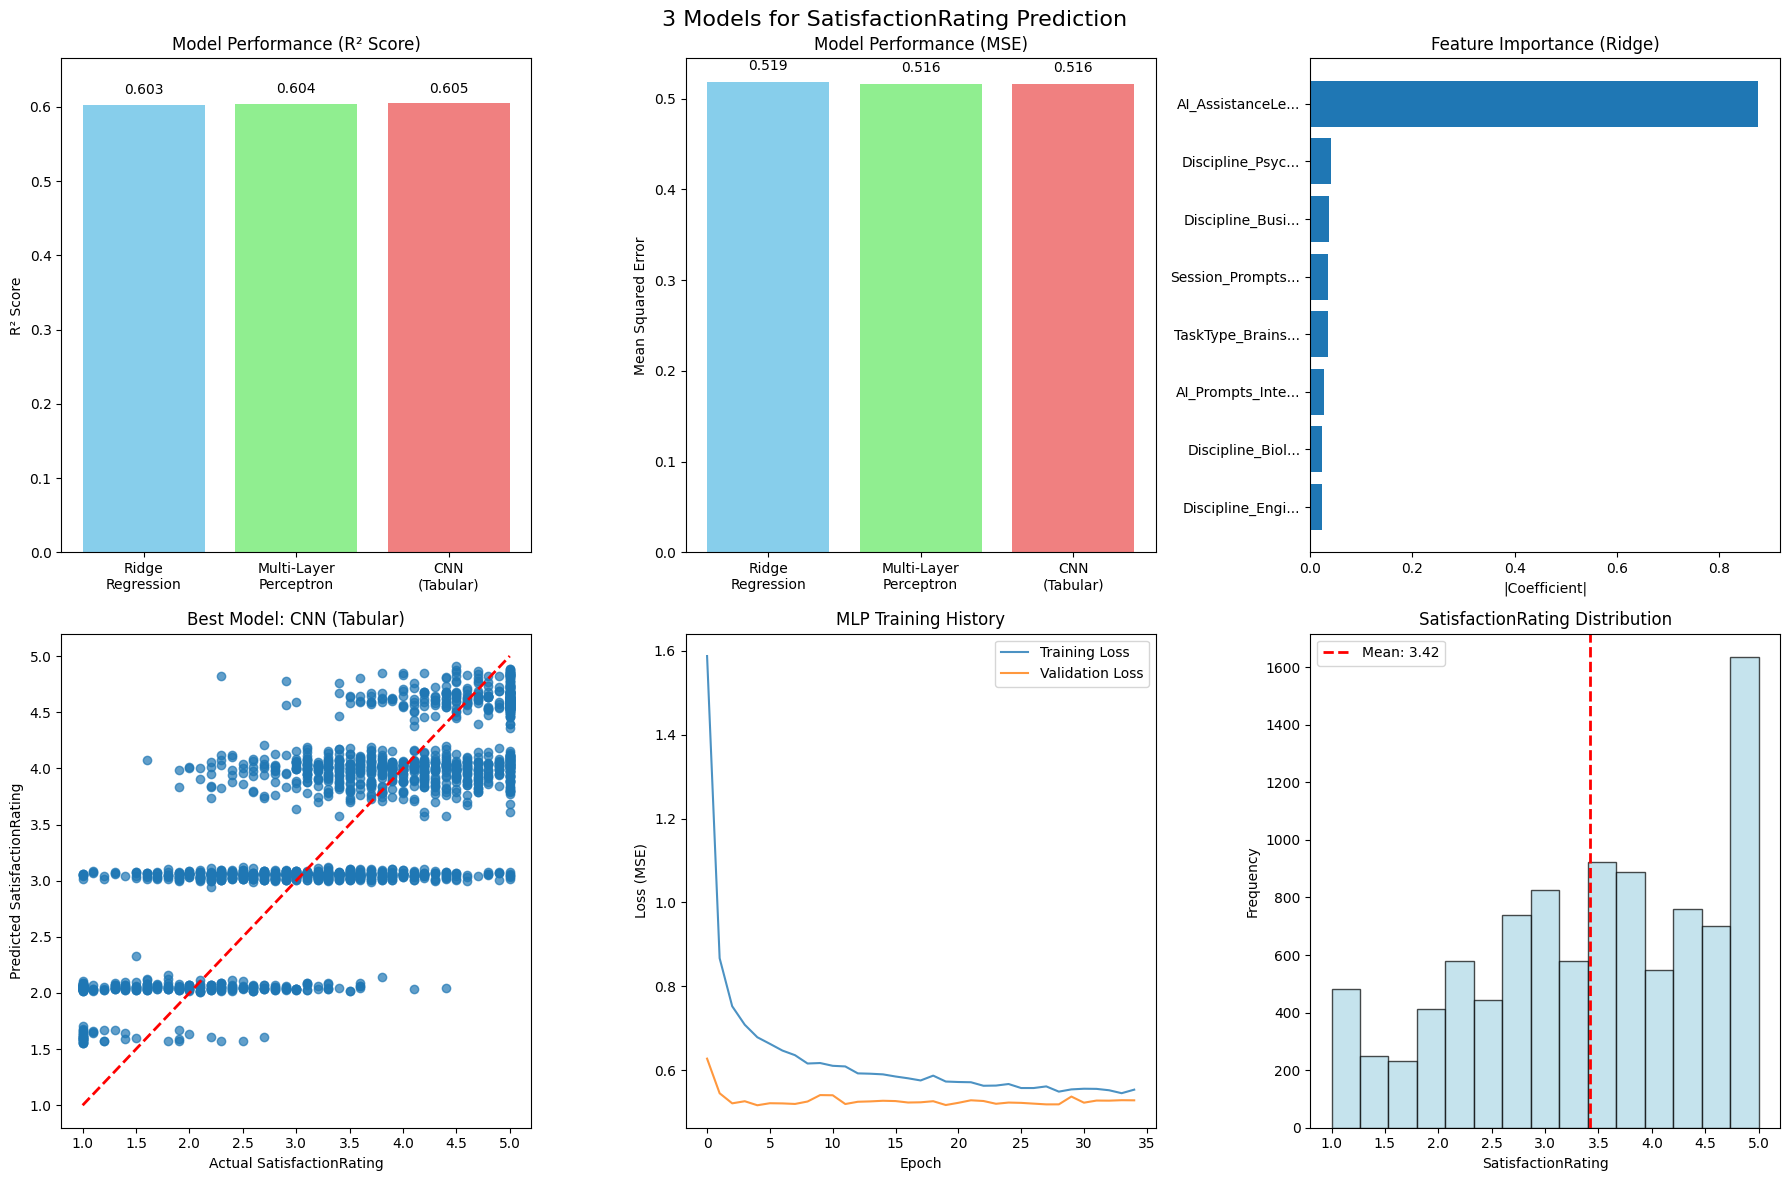

Visualizations completed successfully!


In [11]:
print("Creating Satisfaction Prediction Visualizations...")

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('3 Models for SatisfactionRating Prediction', fontsize=16)

# 1. Model Performance Comparison
models = ['Ridge\nRegression', 'Multi-Layer\nPerceptron', 'CNN\n(Tabular)']
r2_scores = [ridge_results['test_r2'], mlp_results['test_r2'], cnn_results['test_r2']]
mse_scores = [ridge_results['test_mse'], mlp_results['test_mse'], cnn_results['test_mse']]

bars = axes[0, 0].bar(models, r2_scores, color=['skyblue', 'lightgreen', 'lightcoral'])
axes[0, 0].set_title('Model Performance (R² Score)')
axes[0, 0].set_ylabel('R² Score')
axes[0, 0].set_ylim(0, max(r2_scores) * 1.1)

for bar, score in zip(bars, r2_scores):
    axes[0, 0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                   f'{score:.3f}', ha='center', va='bottom')

# 2. MSE Comparison
bars = axes[0, 1].bar(models, mse_scores, color=['skyblue', 'lightgreen', 'lightcoral'])
axes[0, 1].set_title('Model Performance (MSE)')
axes[0, 1].set_ylabel('Mean Squared Error')

for bar, score in zip(bars, mse_scores):
    axes[0, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                   f'{score:.3f}', ha='center', va='bottom')

# 3. Feature Importance (Ridge Regression)
feature_importance = ridge_results['feature_importance']
top_features = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)[:8]
features, importances = zip(*top_features)

axes[0, 2].barh(range(len(features)), importances)
axes[0, 2].set_yticks(range(len(features)))
axes[0, 2].set_yticklabels([f[:15] + '...' if len(f) > 15 else f for f in features])
axes[0, 2].set_title('Feature Importance (Ridge)')
axes[0, 2].set_xlabel('|Coefficient|')
axes[0, 2].invert_yaxis()

# 4. Predictions vs Actual (Best Model)
if best_model[0] == 'Ridge Regression':
    best_results = ridge_results
elif best_model[0] == 'Multi-Layer Perceptron':
    best_results = mlp_results
else:
    best_results = cnn_results

axes[1, 0].scatter(best_results['y_test'], best_results['predictions'], alpha=0.7)
axes[1, 0].plot([best_results['y_test'].min(), best_results['y_test'].max()],
               [best_results['y_test'].min(), best_results['y_test'].max()], 'r--', lw=2)
axes[1, 0].set_xlabel('Actual SatisfactionRating')
axes[1, 0].set_ylabel('Predicted SatisfactionRating')
axes[1, 0].set_title(f'Best Model: {best_model[0]}')

# 5. Training History (MLP)
history = mlp_results['history']
axes[1, 1].plot(history.history['loss'], label='Training Loss', alpha=0.8)
axes[1, 1].plot(history.history['val_loss'], label='Validation Loss', alpha=0.8)
axes[1, 1].set_title('MLP Training History')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Loss (MSE)')
axes[1, 1].legend()

# 6. SatisfactionRating Distribution
axes[1, 2].hist(y, bins=15, alpha=0.7, edgecolor='black', color='lightblue')
axes[1, 2].axvline(y.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {y.mean():.2f}')
axes[1, 2].set_title('SatisfactionRating Distribution')
axes[1, 2].set_xlabel('SatisfactionRating')
axes[1, 2].set_ylabel('Frequency')
axes[1, 2].legend()

plt.tight_layout()
plt.show()

print("Visualizations completed successfully!")

## 10. Key Insights and Recommendations

Based on our comprehensive analysis of student satisfaction prediction using three different models:

In [12]:
print("KEY INSIGHTS FOR SATISFACTION PREDICTION")
print("=" * 60)

# Model performance summary
print(f"\n1. MODEL PERFORMANCE RANKING:")
models_ranked = sorted(models_data, key=lambda x: x[1], reverse=True)
for i, (model, r2, mse, mae) in enumerate(models_ranked, 1):
    print(f"   {i}. {model}: R²={r2:.4f}, MSE={mse:.4f}, MAE={mae:.4f}")

print(f"\n2. FEATURE IMPORTANCE INSIGHTS:")
top_features = sorted(ridge_results['feature_importance'].items(), key=lambda x: x[1], reverse=True)[:5]
for i, (feature, importance) in enumerate(top_features, 1):
    print(f"   {i}. {feature}: {importance:.4f}")

print(f"\n3. SATISFACTION PATTERNS:")
print(f"   - Average satisfaction: {y.mean():.2f}/5.0")
print(f"   - Most common rating: {y.mode().iloc[0]:.1f}")
print(f"   - Rating spread: {y.std():.2f} standard deviation")

print(f"\n4. RECOMMENDATIONS:")
if best_model[0] == 'Ridge Regression':
    print(f"   - Use Ridge Regression for interpretable predictions")
    print(f"   - Focus on top features for satisfaction improvement")
elif best_model[0] == 'Multi-Layer Perceptron':
    print(f"   - MLP captures complex non-linear satisfaction patterns")
    print(f"   - Consider feature interactions for satisfaction optimization")
else:
    print(f"   - CNN effectively detects feature interaction patterns")
    print(f"   - Hierarchical feature learning improves predictions")

print(f"\n5. NEXT STEPS:")
print(f"   - Collect more data to improve model performance")
print(f"   - Experiment with ensemble methods")
print(f"   - Deploy best model for real-time satisfaction prediction")
print(f"   - Monitor model performance and retrain as needed")

KEY INSIGHTS FOR SATISFACTION PREDICTION

1. MODEL PERFORMANCE RANKING:
   1. CNN (Tabular): R²=0.6047, MSE=0.5157, MAE=0.5781
   2. Multi-Layer Perceptron: R²=0.6042, MSE=0.5164, MAE=0.5804
   3. Ridge Regression: R²=0.6025, MSE=0.5186, MAE=0.5702

2. FEATURE IMPORTANCE INSIGHTS:
   1. AI_AssistanceLevel: 0.8747
   2. Discipline_Psychology: 0.0401
   3. Discipline_Business: 0.0359
   4. Session_Prompts_Ratio: 0.0345
   5. TaskType_Brainstorming: 0.0343

3. SATISFACTION PATTERNS:
   - Average satisfaction: 3.42/5.0
   - Most common rating: 5.0
   - Rating spread: 1.14 standard deviation

4. RECOMMENDATIONS:
   - CNN effectively detects feature interaction patterns
   - Hierarchical feature learning improves predictions

5. NEXT STEPS:
   - Collect more data to improve model performance
   - Experiment with ensemble methods
   - Deploy best model for real-time satisfaction prediction
   - Monitor model performance and retrain as needed


## 11. Conclusion

This notebook successfully demonstrated three different approaches to predicting student satisfaction ratings:

1. **Ridge Regression**: Linear model with L2 regularization, perfect for interpretable baseline predictions
2. **Multi-Layer Perceptron**: Neural network capable of capturing non-linear relationships in student behavior
3. **CNN for Tabular Data**: Convolutional approach for detecting feature interaction patterns

The analysis provides a comprehensive framework for understanding and predicting student satisfaction, which can be used to:
- Optimize AI assistant interactions
- Improve student learning experiences
- Identify factors that contribute to higher satisfaction
- Make data-driven decisions for educational technology

**Final Model Recommendation**: Use the best-performing model based on your specific requirements for accuracy vs. interpretability.